<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/YOLOFruitDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mega.py

from mega import Mega

# Crie uma instância da classe Mega
mega = Mega()

# Cole o link completo do Mega.nz (incluindo a chave)
url = "https://mega.nz/file/tu0GXQzL#BGoVzch2_6s2EEQYLfkwpct1Uq-ZrRL2sHCOY54vohs"

# Use o link completo para fazer o download
mega.download_url(url)

!unzip vegetables.v4i.yolov8.zip

In [ ]:
!pip install super-gradients

In [3]:
from PIL import Image
import os
import numpy as np
import torch

import random
import pathlib

from torch.utils.data import Dataset
import json
from torchvision import transforms, utils


import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt


import os

import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

The console stream is logged into /root/sg_logs/console.log


[2023-11-21 23:36:40] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-21 23:36:40] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-21 23:36:40] INFO - utils.py - NumExpr defaulting to 8 threads.
[2023-11-21 23:36:46] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-21 23:36:46] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-21 23:36:46] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-21 23:36:46] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-11-21 23:36:46] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-11-21 23:36:46] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-21 23:36:46] WARNING - env_sanity_check.py - 

In [4]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = '/content/vegetables' #specify the experiment name

    #dataset params
    DATA_DIR = '../content/vegetables' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['apple', 'banana', 'bell_pepper', 'carrot', 'cauliflower', 'chillies', 'cucumber', 'garlic', 'grapes', 'mango', 'mushroom', 'onion', 'orange', 'pear', 'potato', 'promegranate', 'tomato', 'watermelon'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

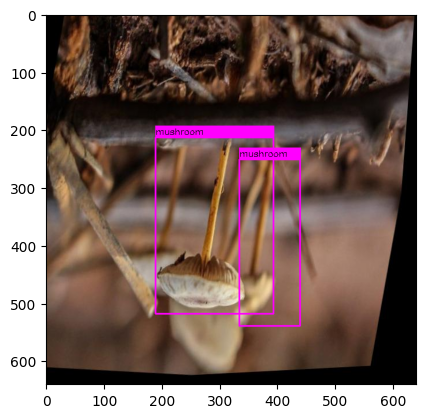

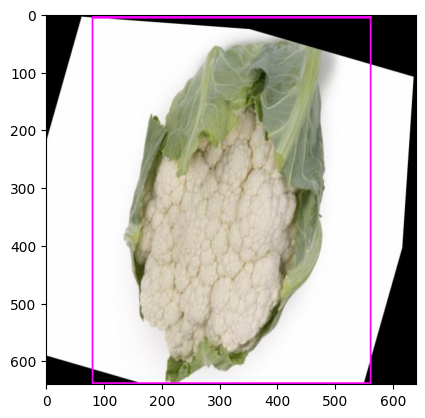

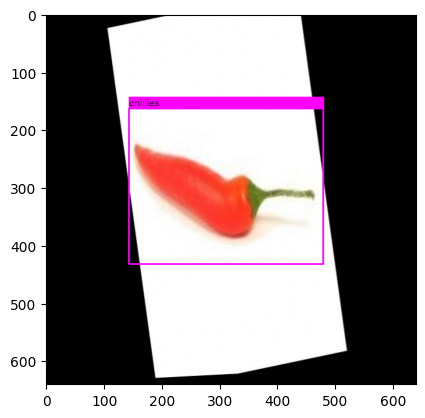

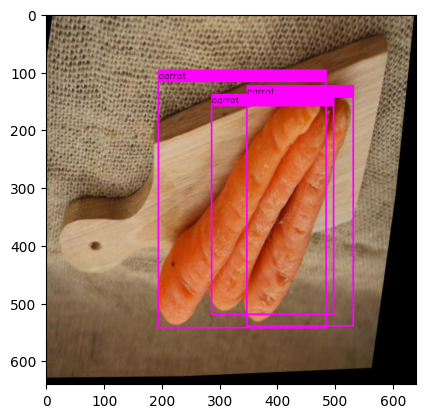

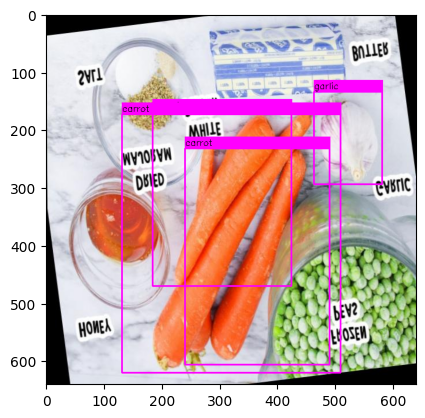

In [7]:
train_images_dir= os.path.join(config.DATA_DIR, config.TRAIN_IMAGES_DIR)
train_labels_dir= os.path.join(config.DATA_DIR, config.TRAIN_LABELS_DIR)
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(train_images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files

selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(train_labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = config.CLASSES

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            #color = colors[class_id]
            #clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [8]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [9]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-11-21 23:39:54] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1775/1775 [00:00<00:00, 5011.71it/s]
[2023-11-21 23:39:54] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 256/256 [00:00<00:00, 5055.71it/s]
[2023-11-21 23:39:54] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:487: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)


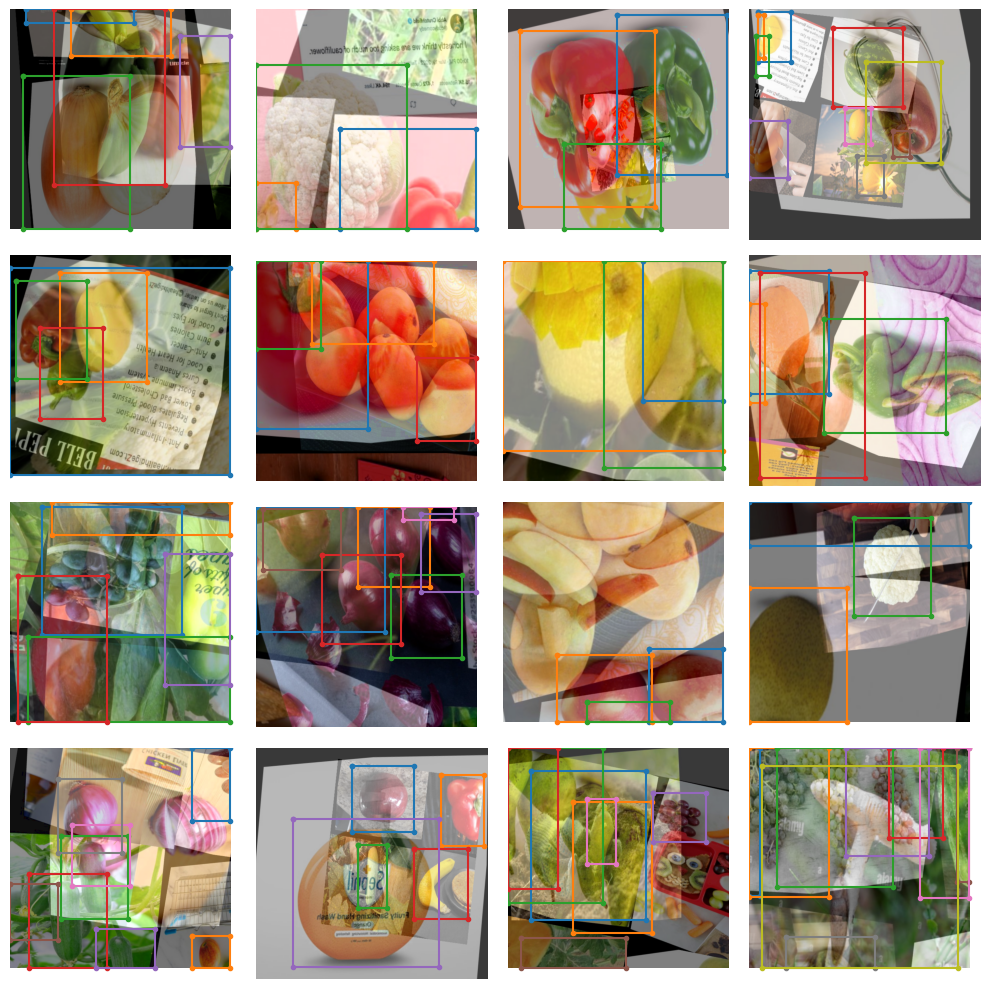

In [10]:
train_data.dataset.plot()

In [11]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2023-11-21 23:40:15] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:14<00:00, 18.1MB/s]
[2023-11-21 23:40:31] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [12]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "lr_warmup_epochs": 5,
    "initial_lr": 3e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        # Adicione a vírgula ou o ponto e vírgula aqui
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-11-21 23:40:43] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231121_234043_450552`
[2023-11-21 23:40:43] INFO - sg_trainer.py - Checkpoints directory: /content/vegetables/RUN_20231121_234043_450552
[2023-11-21 23:40:43] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/vegetables/RUN_20231121_234043_450552/console_Nov21_23_40_43.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/sg_trainer/sg_trainer.py:1670: UserWarning: Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
  warnings.warn("Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)")
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:487: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating 

In [ ]:
#https://www.kaggle.com/code/harpdeci/yolo-nas-fruit-detection/notebook